In [23]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
# File paths
Cleanfile = r"/Users/livalacaisse/Documents/DataScience/CO2/000-C02 First Delivery/Cleaned_countries/FR_Cleaned.csv"


# Data types specification
dtype_spec = {
    'Em_on_target': 'int64',
    'Fuel consumption': 'float32',
    'Engine_cm3': 'float32',
    'Kg_veh': 'float32',
    'Test_mass': 'float32',
    'Power_KW': 'float32',
    'El_Consumpt_whkm': 'float32',
    'Energy': 'category',
    'Fuel_mode': 'category',
    'Brand': 'category',
    'Veh_type': 'category',
    'Veh_Model': 'category',
    'Version': 'category',
    'Veh_Category': 'category',
    'year': 'int64',
    'Country': 'category'
}

# Load data
df_clean = pd.read_csv(Cleanfile, dtype=dtype_spec, low_memory=False)
drop =["Unnamed: 0","Em_on_target"]
df_clean = df_clean.drop(drop, axis=1)

df_clean.drop_duplicates(inplace=True)

In [25]:
#df_clean.info()

In [26]:
# Encode categorical variables
#label_encoders = {}
#for column in df_clean.select_dtypes(include=['category']).columns:
    #label_encoders[column] = LabelEncoder()
    #df_clean[column] = label_encoders[column].fit_transform(df_clean[column])

# Display the first few rows to verify
#df_clean.head()

In [27]:
# Define the features for each energy type
features_dict = {
    'petrol': ['Fuel consumption', 'Wheelbase_mm', 'Engine_cm3', 'Power_KW', 'Axle_width_steer_mm', 
               'Test_mass', 'Axle_width_other_mm', 'Eco-innovation program', 'Kg_veh', 'year', 
               'Erwltp (g/km)', 'El_Consumpt_whkm'],
    'diesel': ['Wheelbase_mm', 'Axle_width_other_mm', 'Power_KW', 'Test_mass', 'Axle_width_steer_mm', 
               'Kg_veh', 'Engine_cm3', 'Fuel consumption', 'year', 'Erwltp (g/km)', 'Eco-innovation program', 
               'El_Consumpt_whkm'],
    'lpg': ['Kg_veh', 'Fuel consumption', 'Axle_width_steer_mm', 'Axle_width_other_mm', 'year', 'Test_mass', 
            'Power_KW', 'Erwltp (g/km)', 'Engine_cm3', 'Wheelbase_mm', 'Eco-innovation program', 
            'Electric range (km)'],
    'hybrid petrol': ['Engine_cm3', 'Axle_width_other_mm', 'Axle_width_steer_mm', 'Fuel consumption', 
                     'El_Consumpt_whkm', 'Power_KW', 'Electric range (km)', 'year', 'Wheelbase_mm', 
                     'Eco-innovation program', 'Test_mass', 'Kg_veh'],
    'hybrid diesel': ['El_Consumpt_whkm', 'Axle_width_other_mm', 'Electric range (km)', 'Axle_width_steer_mm', 
                     'year', 'Kg_veh', 'Test_mass', 'Fuel consumption', 'Wheelbase_mm', 'Eco-innovation program', 
                     'Erwltp (g/km)', 'Power_KW']
}

In [28]:
# Function to prepare data for regression
def prepare_data(df, energy_types, features_dict):
    if isinstance(energy_types, list):
        dfs = []
        for energy in energy_types:
            df_energy = df[df['Energy'] == energy].copy()
            if df_energy.empty:
                print(f"No data for energy type: {energy}")
                continue
            df_energy = df_energy[features_dict[energy] + ['CO2_wltp']]
            dfs.append(df_energy)
        if not dfs:
            return pd.DataFrame(), pd.Series(), []
        df_combined = pd.concat(dfs, axis=0)
        features = [feat for energy in energy_types for feat in features_dict[energy]]
        features = list(set(features))  # Remove duplicates
    else:
        df_combined = df[df['Energy'] == energy_types].copy()
        if df_combined.empty:
            print(f"No data for energy type: {energy_types}")
            return pd.DataFrame(), pd.Series(), []
        features = features_dict[energy_types]
    
    X = df_combined[features]
    y = df_combined['CO2_wltp']
    
    return X, y, features

In [29]:
# Ridge Regression function with RandomizedSearchCV and enhanced visualization
def ridge_regression_with_random_search(df, energy_types, features_dict, alphas):
    # Prepare data
    X, y, feature_names = prepare_data(df, energy_types, features_dict)
    
    if X.empty or y.empty:
        print(f"No data available for energy types: {energy_types}")
        return None, None, None
    
    # Handle missing values
    X = X.fillna(X.mean())  # Avoid SettingWithCopyWarning
    
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    
    # Parameter grid for alpha
    param_grid = {'alpha': alphas}
    
    # Ridge Regression with RandomizedSearchCV
    ridge = Ridge()
    random_search = RandomizedSearchCV(ridge, param_distributions=param_grid, n_iter=100, cv=5, random_state=42, n_jobs=-1)
    random_search.fit(X_train, y_train)
    
    # Best model
    best_ridge = random_search.best_estimator_
    best_alpha = random_search.best_params_['alpha']
    
    # Predictions with best model
    y_pred_best = best_ridge.predict(X_test)
    
    # Evaluation of best model
    best_r2 = r2_score(y_test, y_pred_best)
    mse_best = mean_squared_error(y_test, y_pred_best)
    
    # Results reporting
    print(f"Energy Type: {'All' if isinstance(energy_types, list) else energy_types}")
    print(f"Best Alpha: {best_alpha}")
    print(f"Best R^2 Score: {best_r2}")
    print(f"Mean Squared Error: {mse_best}")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # Scatter plot of actual vs predicted for best model
    sns.scatterplot(x=y_test, y=y_pred_best, ax=axes[0])
    axes[0].set_xlabel('Actual CO2_wltp')
    axes[0].set_ylabel('Predicted CO2_wltp')
    axes[0].set_title(f'Regression Results for {"All Energies" if isinstance(energy_types, list) else energy_types}')
    
    # R^2 scores vs alpha plot
    results_df = pd.DataFrame(random_search.cv_results_)
    sns.lineplot(x='param_alpha', y='mean_test_score', data=results_df, ax=axes[1])
    axes[1].set_xlabel('Alpha')
    axes[1].set_ylabel('Mean CV R^2 Score')
    axes[1].set_title('Mean CV R^2 Score vs Alpha')
    
    plt.tight_layout()
    plt.show()
    
    # Print feature importance for best model
    coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': np.abs(best_ridge.coef_)})
    coef_df = coef_df.sort_values(by='Coefficient', ascending=False)
    
    print("Feature Importances:")
    for feature, coef in zip(coef_df['Feature'], coef_df['Coefficient']):
        print(f"{feature}: {coef}")
    
    # Visualization of feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Coefficient', y='Feature', data=coef_df)
    plt.axvline(x=0, color='red', linestyle='--')
    plt.title('Feature Coefficients')
    plt.tight_layout()
    plt.show()
    
    return best_ridge, best_r2, mse_best

Energy Type: petrol
Best Alpha: 0.05336699231206313
Best R^2 Score: 0.8384259898028528
Mean Squared Error: 130.05793170336992


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


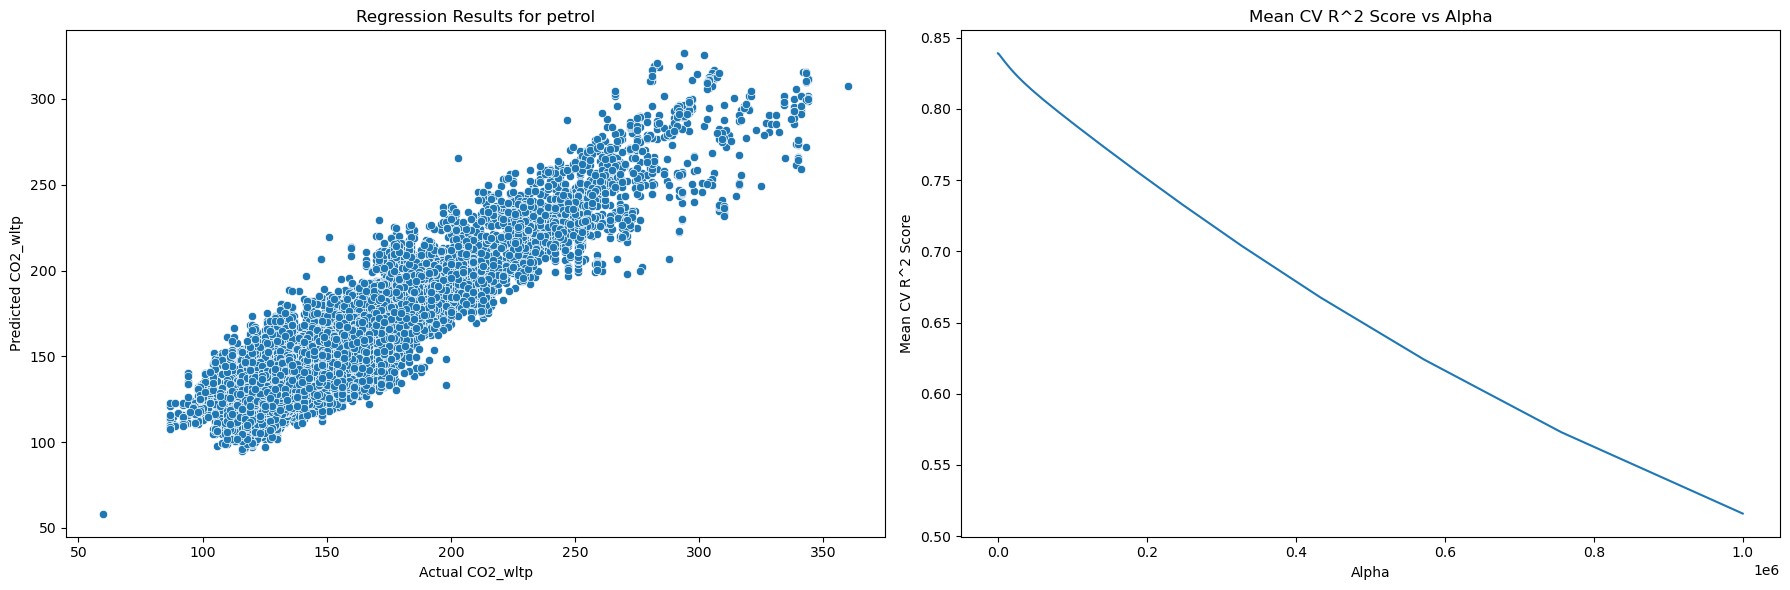

Feature Importances:
Test_mass: 18.219886357627313
Power_KW: 15.523482474852178
year: 6.469642071507159
Wheelbase_mm: 5.462902711755942
Axle_width_steer_mm: 3.9504909033088245
Fuel consumption: 2.6882568627896015
Kg_veh: 2.3447137097836275
Engine_cm3: 1.6543104751372175
Axle_width_other_mm: 1.1079020248183378
Erwltp (g/km): 0.8263036871263233
Eco-innovation program: 0.17401946589088615
El_Consumpt_whkm: 0.1474739441658435


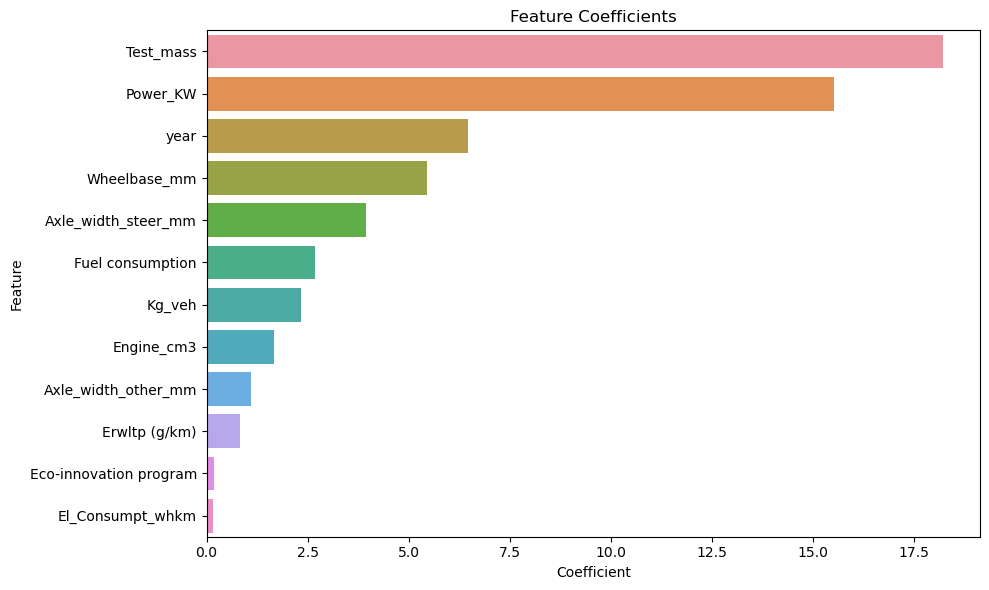

Energy Type: diesel
Best Alpha: 0.8697490026177834
Best R^2 Score: 0.8416638198199332
Mean Squared Error: 105.63504651076923


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


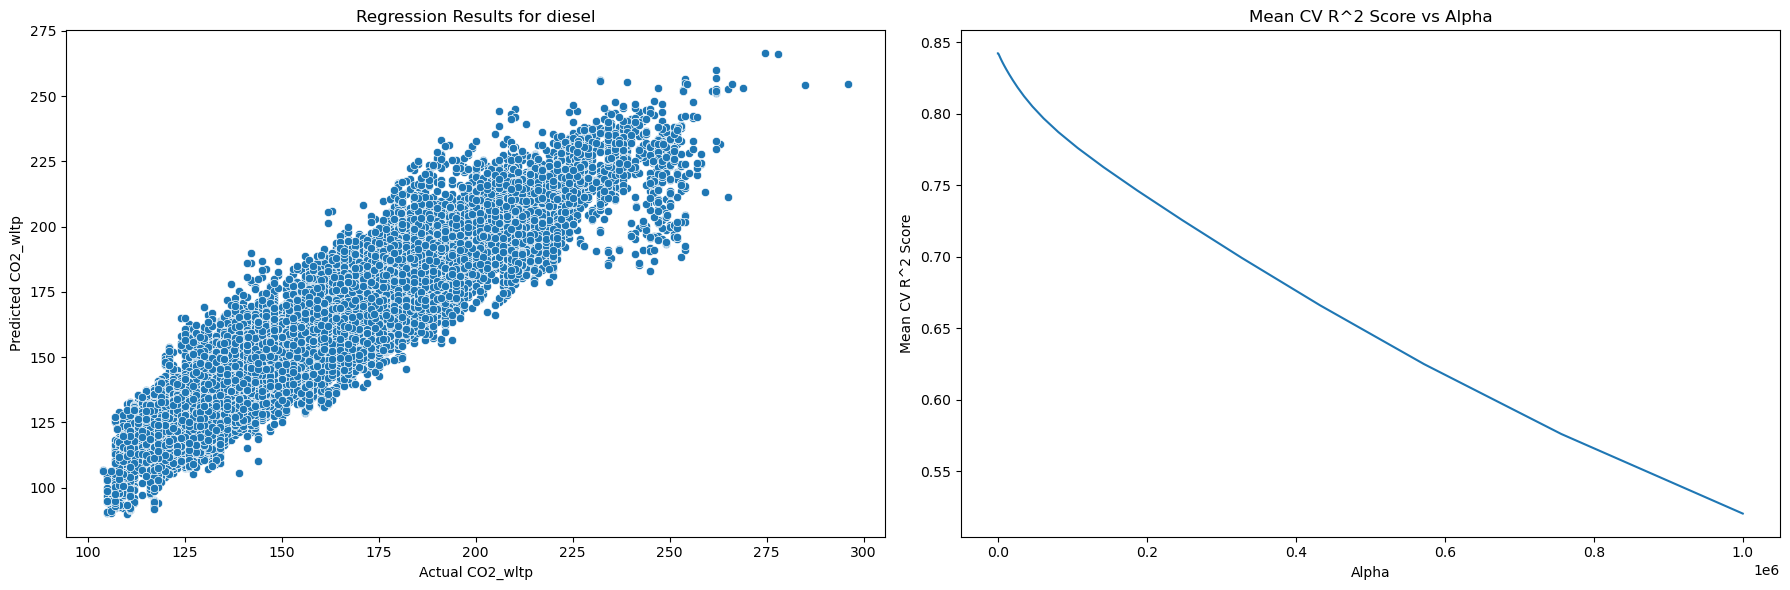

Feature Importances:
Test_mass: 26.531263428706605
Wheelbase_mm: 6.110392956481362
year: 5.75498674178323
Axle_width_steer_mm: 3.4131186821200146
Fuel consumption: 2.6227919269759505
Eco-innovation program: 1.529524537235891
Power_KW: 0.5365529856546142
Erwltp (g/km): 0.46815695110434535
Engine_cm3: 0.35958284551373276
Kg_veh: 0.3177568758036862
Axle_width_other_mm: 0.08402599558688469
El_Consumpt_whkm: 0.023925165100976625


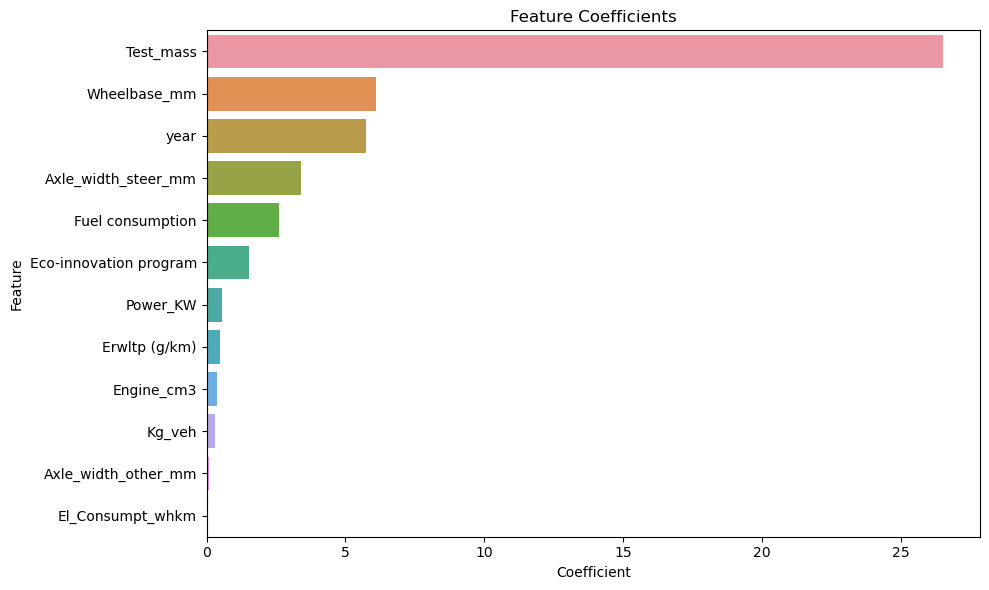

Energy Type: lpg
Best Alpha: 0.37649358067924715
Best R^2 Score: 0.946661663680668
Mean Squared Error: 13.106478429117187


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


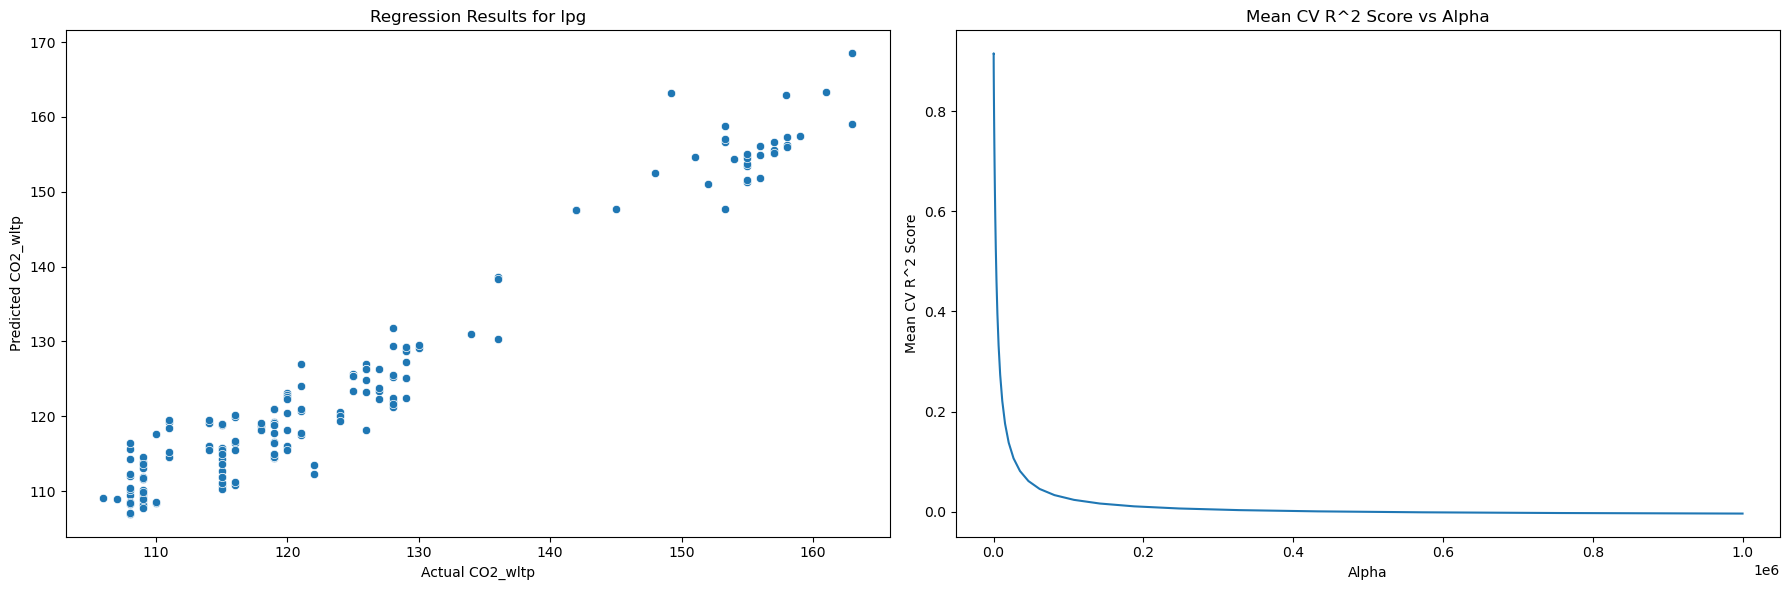

Feature Importances:
Axle_width_steer_mm: 13.84357055114834
Axle_width_other_mm: 12.378043564785887
Test_mass: 8.885547954331608
Engine_cm3: 7.24009298491989
year: 4.975580910287532
Eco-innovation program: 2.1554987998972113
Kg_veh: 1.8227595351177706
Power_KW: 1.4451123810282804
Erwltp (g/km): 0.9176303543557357
Wheelbase_mm: 0.7455320310535161
Fuel consumption: 0.018742582017145275
Electric range (km): 0.0


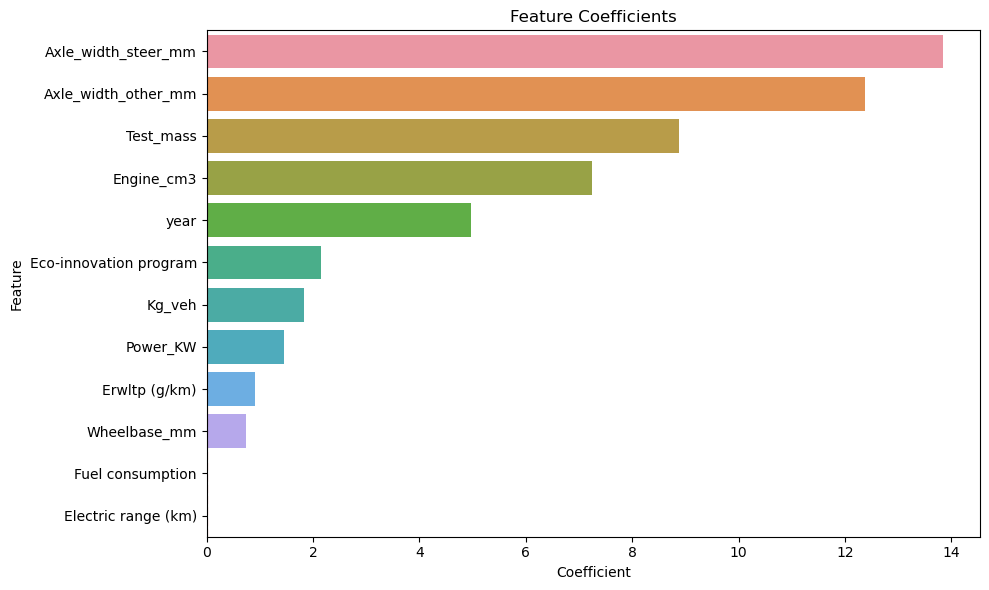

Energy Type: hybrid petrol
Best Alpha: 2.6560877829466896
Best R^2 Score: 0.5900337754873344
Mean Squared Error: 161.78649258311685


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


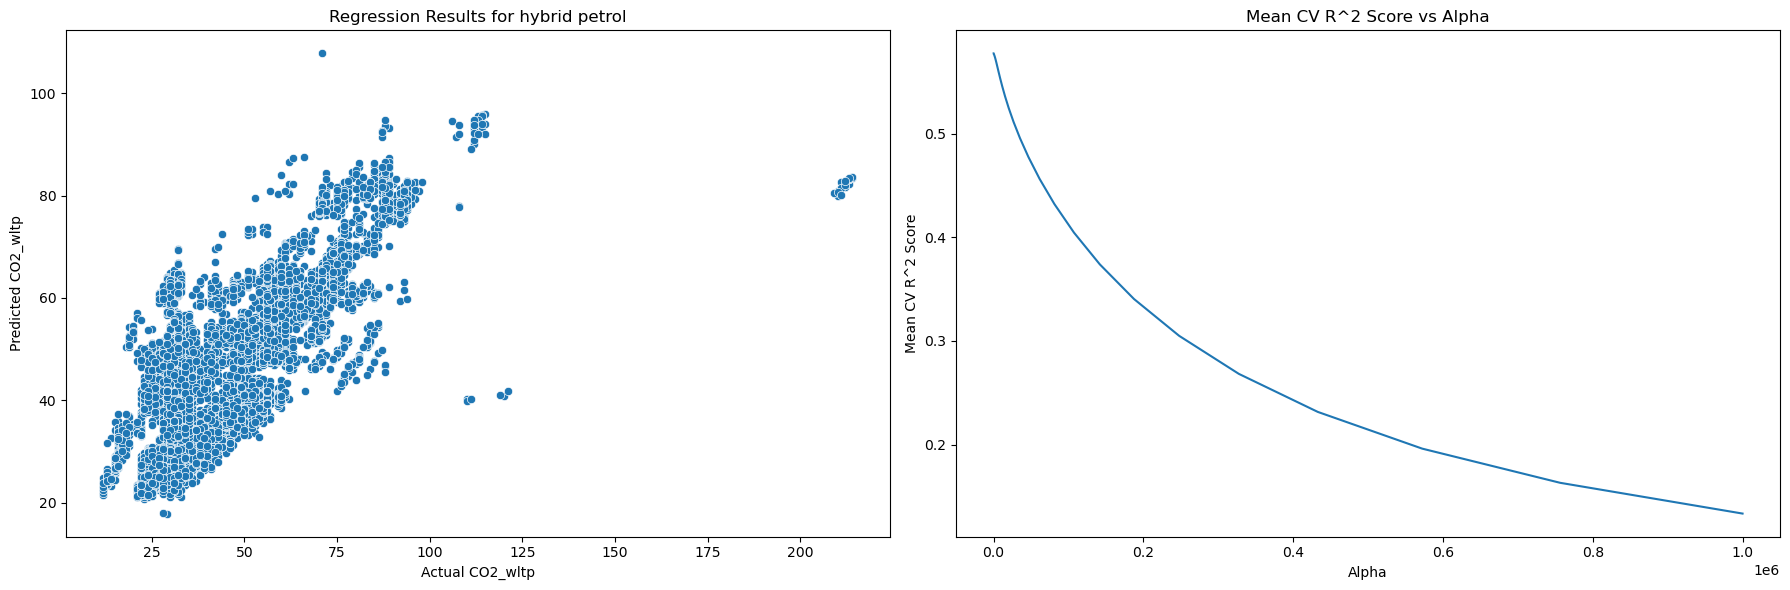

Feature Importances:
Test_mass: 10.921059500375993
Fuel consumption: 9.847383973816369
Power_KW: 5.9784894199766665
Wheelbase_mm: 4.908606603140501
Axle_width_steer_mm: 4.393850503293213
Kg_veh: 4.170631972901712
Electric range (km): 2.1978531905388183
Engine_cm3: 2.016626113873595
El_Consumpt_whkm: 1.2024198260832013
year: 1.1318535310130702
Axle_width_other_mm: 1.0353799323355124
Eco-innovation program: 0.10225071686868645


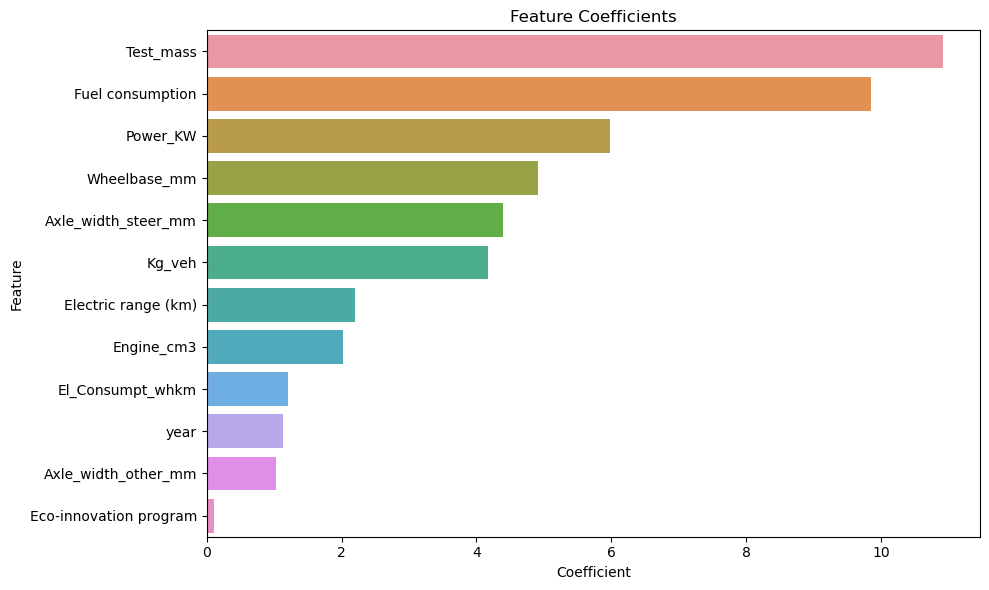

Energy Type: hybrid diesel
Best Alpha: 0.16297508346206435
Best R^2 Score: 0.9926227920301289
Mean Squared Error: 1.321051548832908


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


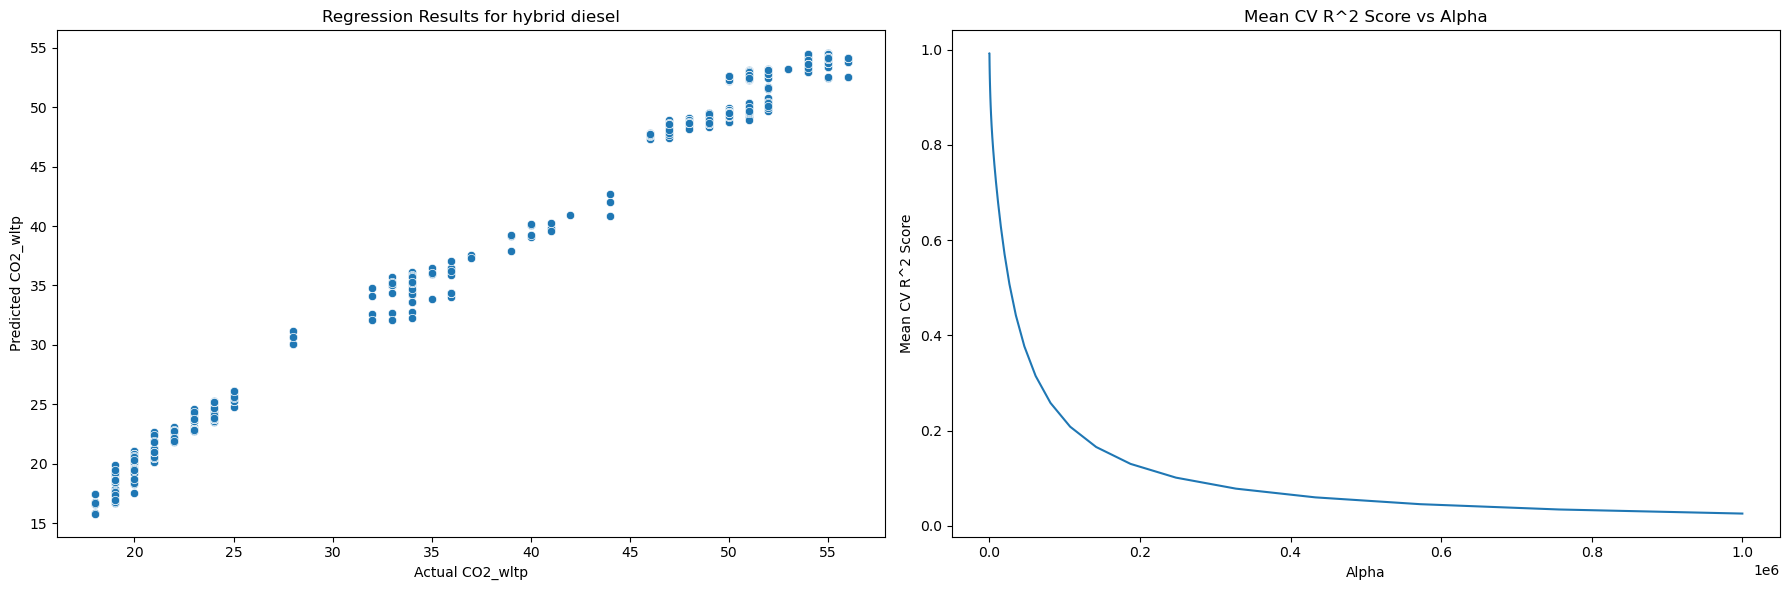

Feature Importances:
Electric range (km): 16.50757203425997
Axle_width_other_mm: 4.37020390471167
Axle_width_steer_mm: 3.745092679051661
Kg_veh: 3.688212710668837
Wheelbase_mm: 0.8829180781958751
El_Consumpt_whkm: 0.5914846467178144
Test_mass: 0.44798418219738617
Fuel consumption: 0.3000938693915978
year: 0.19283227269673975
Eco-innovation program: 0.0
Erwltp (g/km): 0.0
Power_KW: 0.0


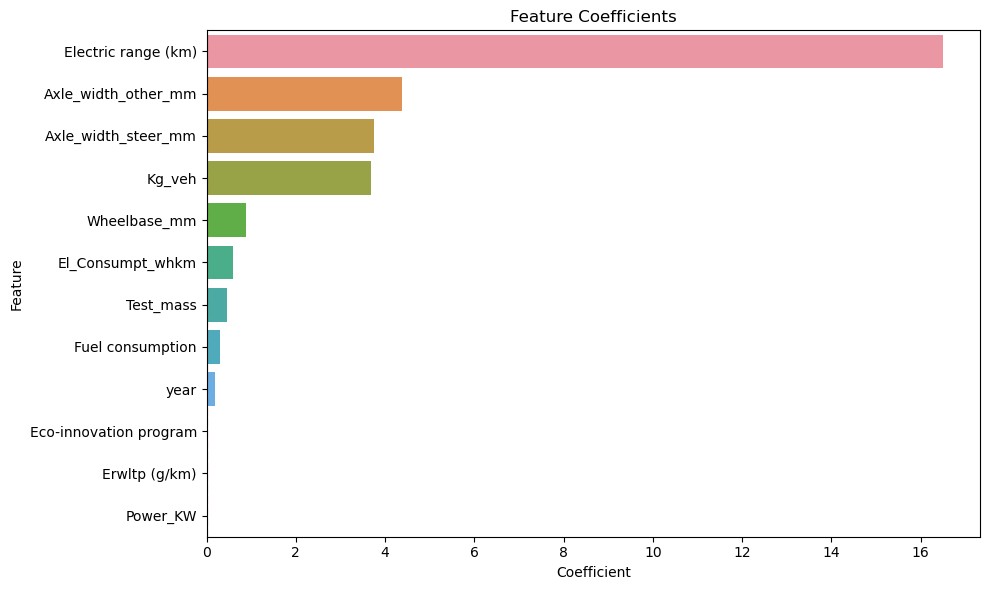

In [30]:
# Apply Ridge Regression for each energy type and all together with enhanced visualization
alphas = np.logspace(-6, 6, 100)
results = {}
for energy, features in features_dict.items():
    results[energy] = ridge_regression_with_random_search(df_clean, energy, features_dict, alphas)

In [31]:
# Run regression on all energies together
all_energies = list(features_dict.keys())
results['all_energies'] = ridge_regression_with_alphas(df_clean, all_energies, features_dict, alphas)

NameError: name 'ridge_regression_with_alphas' is not defined

In [ ]:
def visualize_vehicle_count_by_energy(df):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='Energy', order=df['Energy'].value_counts().index)
    plt.title('Vehicle Count by Energy Type')
    plt.xlabel('Energy Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Call the function to visualize
visualize_vehicle_count_by_energy(df_clean)

In [ ]:
# Assuming df_Clean has been loaded as per the previous context
# Visualize vehicle count by Energy
def visualize_vehicle_count_by_energy(df):
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(data=df, x='Energy', order=df['Energy'].value_counts().index)
    
    # Add count labels on top of each bar
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 10), 
                    textcoords = 'offset points')
    
    plt.title('Vehicle Count by Energy Type')
    plt.xlabel('Energy Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Call the function to visualize
visualize_vehicle_count_by_energy(df_clean)